# Lesson 6: pets revisited

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *

from my_python_tricks import *

In [4]:
gpu_device = 0
defaults.device = torch.device(f'cuda:{gpu_device}')
torch.cuda.set_device(gpu_device)

In [5]:
bs = 64

In [6]:
path = untar_data(URLs.PETS)/'images'

## Data augmentation

In [7]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [8]:
doc(get_transforms)

get_transforms [source] get_transforms ( do_flip : bool = True , flip_vert : bool = False , max_rotate : float = 10.0 , max_zoom : float = 1.1 , max_lighting : float = 0.2 , max_warp : float = 0.2 , p_affine : float = 0.75 , p_lighting : float = 0.75 , xtra_tfms : Optional [ Collection [ Transform ]]= None ) → Collection [ Transform ] 
 
 Utility func to easily create a list of flip, rotate, zoom , warp, lighting transforms. 
 Show in docs

In [9]:
src = ImageItemList.from_folder(path).random_split_by_pct(0.2, seed=2)

In [10]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [11]:
data = get_data(224, bs, 'zeros')

plot_multi needs updating fastai

In [12]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

NameError: name 'plot_multi' is not defined

In [13]:
data = get_data(224,bs)

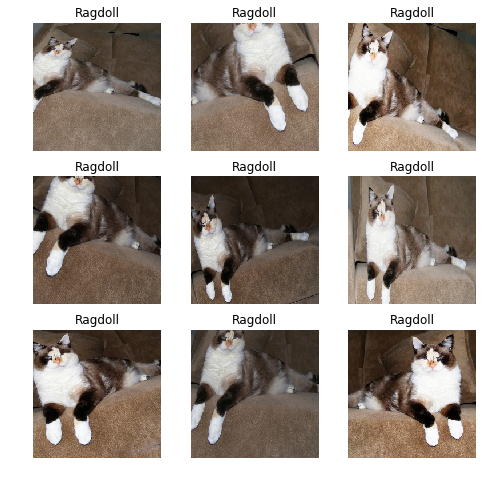

In [12]:
plot_multi(_plot, 3, 3, figsize=(8,8))

## Train a model

In [13]:
??gc

Type:        module
String form: <module 'gc' (built-in)>
Docstring:  
This module provides access to the garbage collector for reference cycles.

enable() -- Enable automatic garbage collection.
disable() -- Disable automatic garbage collection.
isenabled() -- Returns true if automatic collection is enabled.
collect() -- Do a full collection right now.
get_count() -- Return the current collection counts.
get_stats() -- Return list of dictionaries containing per-generation stats.
set_debug() -- Set debugging flags.
get_debug() -- Get debugging flags.
set_threshold() -- Set the collection thresholds.
get_threshold() -- Return the current the collection thresholds.
get_objects() -- Return a list of all objects tracked by the collector.
is_tracked() -- Returns true if a given object is tracked.
get_referrers() -- Return the list of objects that refer to an object.
get_referents() -- Return the list of objects that an object refers to.
freeze() -- Freeze all tracked objects and ignore them

In [14]:
gc.collect()
learn = create_cnn(data, models.resnet34, metrics=error_rate, bn_final=True)

In [15]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate
1,2.805217,1.633573,0.290257
2,1.691880,0.361689,0.085250
3,1.008941,0.292946,0.084574


In [16]:
doc(learn.fit_one_cycle)

fit_one_cycle [source] fit_one_cycle ( learn : Learner , cyc_len : int , max_lr : Union [ float , Collection [ float ], slice ]= slice(None, 0.003, None) , moms : Point = (0.95, 0.85) , div_factor : float = 25.0 , pct_start : float = 0.3 , wd : float = None , callbacks : Optional [ Collection [ Callback ]]= None , kwargs ) 
 
 Fit a model following the 1cycle policy. 
 Show in docs

In [17]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8) 
# pct_start : Percentage of total number of iterations when learning rate rises during one cycle.
# which means:  lr both increase and decrease during same epoch. In your example, say, you have 100 iterations per epoch, then for half an epoch (0.8 * 100 * 2 epochs) = 160) lr will rise, then slowly decrease.

epoch,train_loss,valid_loss,error_rate
1,0.755424,0.336394,0.075101
2,0.726846,0.321550,0.072395


In [18]:
data = get_data(352,bs)
learn.data = data

In [19]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.732761,0.351766,0.065629
2,0.734294,0.362113,0.066306


In [20]:
learn.save('352')

In [21]:
from my_python_tricks import *
notify_me()

## Convolution kernel

In [ ]:
data = get_data(352,16)

In [ ]:
learn = create_cnn(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

Category Maine_Coon

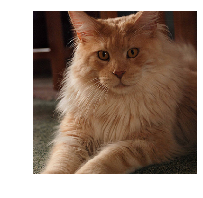

In [ ]:
idx=0
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [ ]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [ ]:
from fastai.callbacks.hooks import *

In [ ]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [ ]:
k.shape

torch.Size([1, 3, 3, 3])

In [ ]:
t = data.valid_ds[0][0].data; t.shape

torch.Size([3, 352, 352])

In [ ]:
t[None].shape

torch.Size([1, 3, 352, 352])

In [ ]:
edge = F.conv2d(t[None], k)

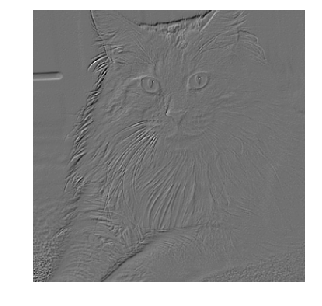

In [ ]:
show_image(edge[0], figsize=(5,5));

In [ ]:
data.c

37

In [ ]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
learn.summary()

Input Size override by Learner.data.train_dl
Input Size passed in: 16 

Layer (type)               Output Shape         Param #   
Conv2d                    [16, 64, 176, 176]   9408                
________________________________________________________________________________
BatchNorm2d               [16, 64, 176, 176]   128                 
________________________________________________________________________________
ReLU                      [16, 64, 176, 176]   0                   
________________________________________________________________________________
MaxPool2d                 [16, 64, 88, 88]     0                   
________________________________________________________________________________
Conv2d                    [16, 64, 88, 88]     36864               
________________________________________________________________________________
BatchNorm2d               [16, 64, 88, 88]     128                 
________________________________________________________

## Heatmap

In [ ]:
m = learn.model.eval();

In [ ]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [ ]:
from fastai.callbacks.hooks import *

In [ ]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [ ]:
hook_a,hook_g = hooked_backward()

In [ ]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [ ]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

In [ ]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

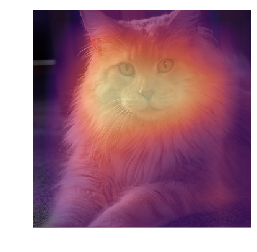

In [ ]:
show_heatmap(avg_acts)

## Grad-CAM

Paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In [ ]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

In [ ]:
mult = (acts*grad_chan[...,None,None]).mean(0)

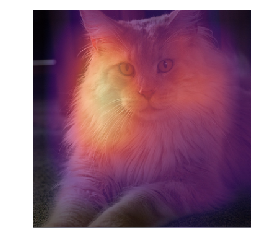

In [ ]:
show_heatmap(mult)

In [ ]:
fn = path/'../other/bulldog_maine.jpg'

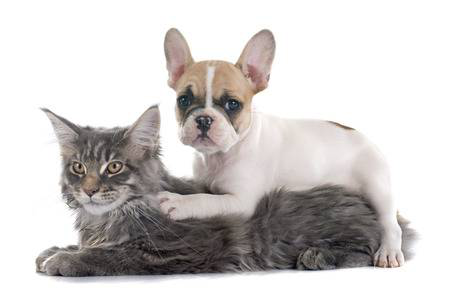

In [ ]:
x = open_image(fn); x

In [ ]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [ ]:
hook_a,hook_g = hooked_backward()

In [ ]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

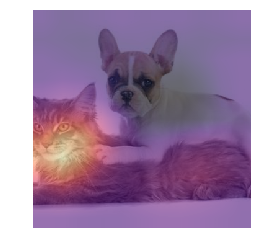

In [ ]:
show_heatmap(mult)

In [ ]:
data.classes[0]

'american_bulldog'

In [ ]:
hook_a,hook_g = hooked_backward(0)

In [ ]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

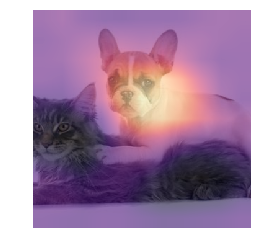

In [ ]:
show_heatmap(mult)

## fin